<a href="https://colab.research.google.com/github/anatejerom/PRA3024/blob/main/Assignment_1_challenge_2_week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
from gwpy.timeseries import TimeSeries
data = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

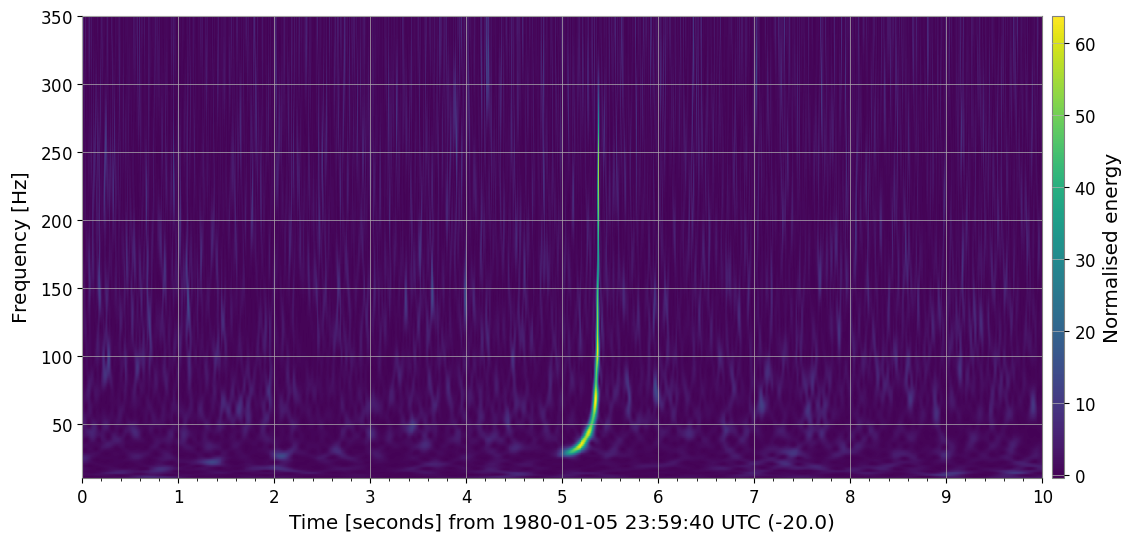

In [3]:
#Plot of q transform to help us find the time of the merger
q = data.q_transform(frange=(10, 350),qrange=(10, 300), outseg=(-20, -10))
plot = q.plot()
plot.colorbar(label="Normalised energy")

In [ ]:
#the approximate time of merger is between -14 and -15, roughly at about -14.6
print(data) #to show data

TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: None)


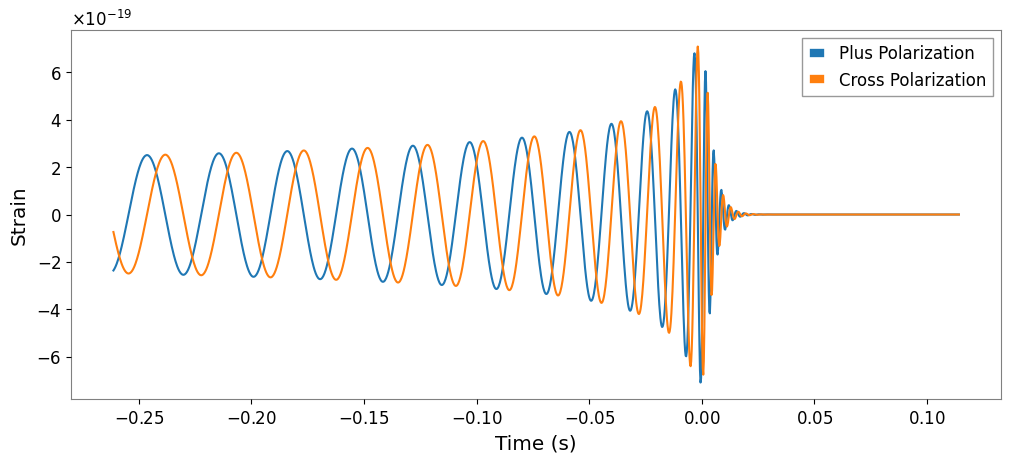

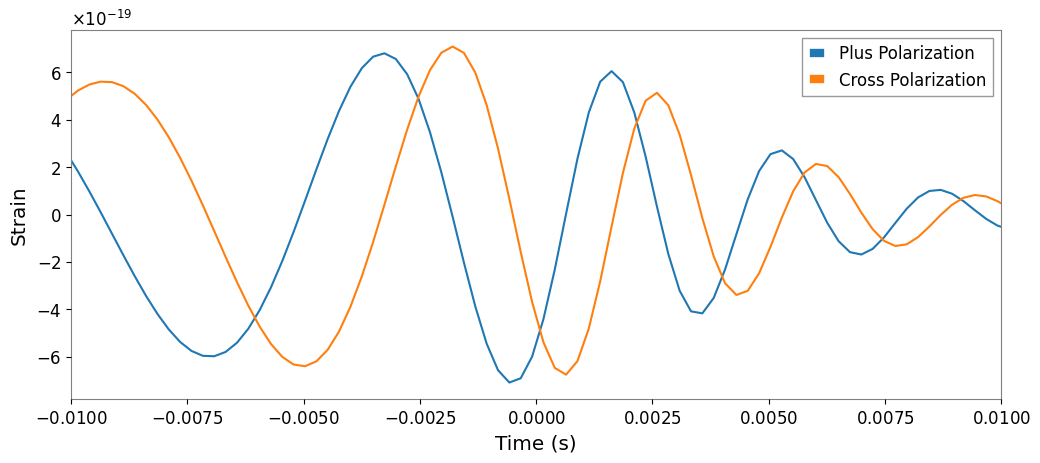

In [4]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", # selecting this as an approximate
                         mass1=30, #masses are the same and equal to 30
                         mass2=30,
                         delta_t=0.000244140625, #copy the delta t shown in the data displayed above
                         f_lower=30)

# To generate time-domain template waveform
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# To zoom in to the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

In [5]:
data.sample_rate # to see the value for sample rate

<Quantity 4096. Hz>

(20, 2048)

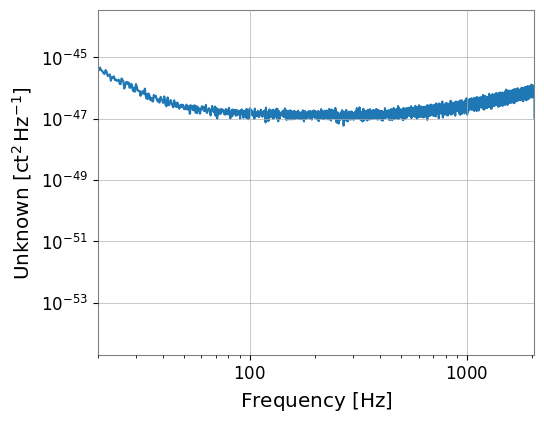

In [6]:
#Plotting the PSD in a log-log scale
psd = data.psd(fftlength = 4, method = "median")
plot = psd.plot(yscale='log', xscale= 'log')
ax = plot.gca()
ax.set_xlim(20,2048) ##The Nyquist frequency is half of the sampling rate

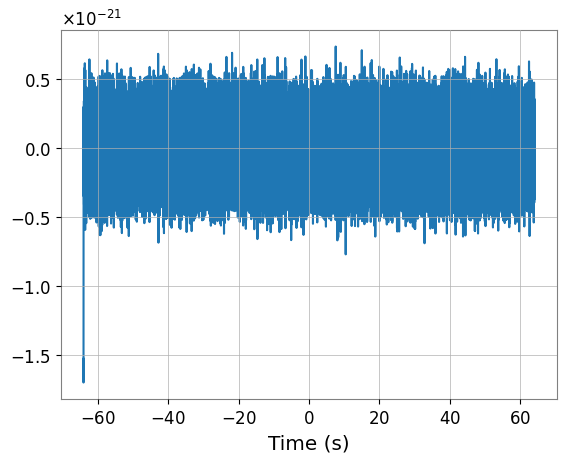

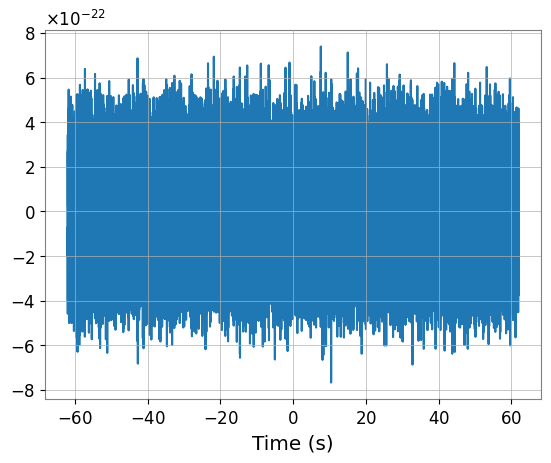

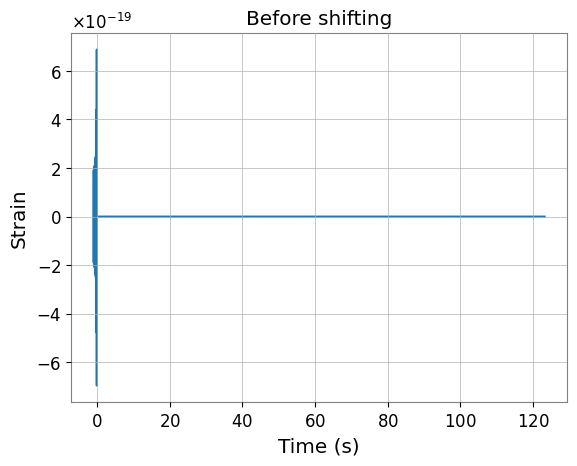

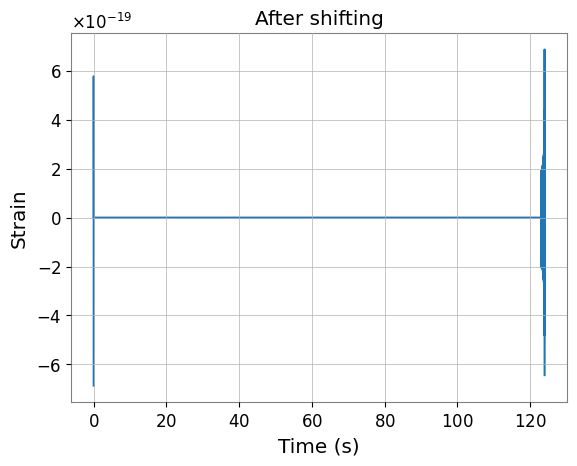

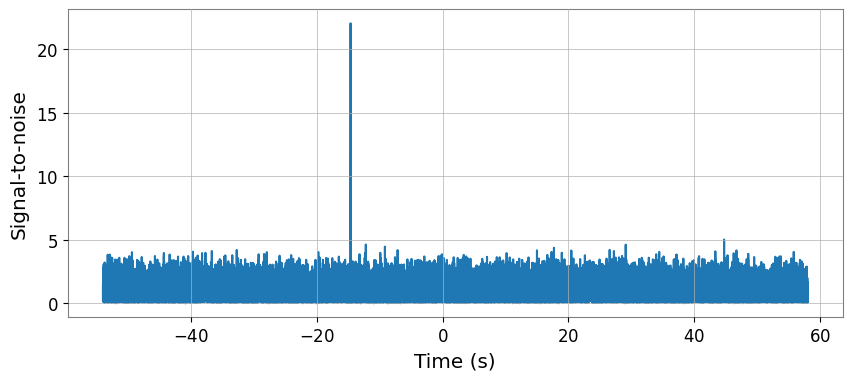

We found a signal at -14.6328125s with SNR 22.054545591712557


In [10]:
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

#Using template waveform and PSD to calculate SNR
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

strain = pycbc_strain
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)


pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

In [ ]:
##The matched filter SNR is 22.054545591712557